<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sat Nov 11 12:16:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

A good practice is to start small ( get a subset of the dataset ) and then upscale to the full dataset.

The dataset is a subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per classe (750 training, 250 testing).

Our dataset starts with 3 classes of foof and only 10% of the images ( ~75 training, 25 testing).


In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data prep and data exploration)

In [6]:
import os
def walk_trhough_dir(dir_path):
  """Walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_trhough_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [8]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path / "test"

In [9]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Visualizing and image

Let's write some code to:

1. Get all of the image paths
2. Piack a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL

Random image path: data/pizza_steak_sushi/train/sushi/390178.jpg
Image class: sushi
Image height: 384
Image width: 512
Image shape: (384, 512, 3)


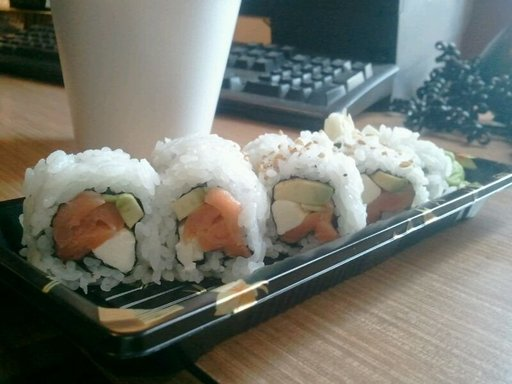

In [10]:
import random
import numpy as np
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (aka the name of the directory) (.parent gives the full path and .stem the last dir)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
image_as_array = np.asarray(img)
print(f"Image shape: {image_as_array.shape}")


img

## 3. Transforming data

Before using the image data with PyTorch:

1. Turn the target data into tensors (in our case, numerical representation of the images)

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`.

We'll call these `Dataset` and `DataLoader` respectively.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 Transforming data with `torchvision.transforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.4118, 0.4039, 0.3961,  ..., 0.0314, 0.2392, 0.7137],
         [0.4196, 0.4118, 0.4000,  ..., 0.0980, 0.2784, 0.4706],
         [0.4235, 0.4118, 0.4039,  ..., 0.1569, 0.2078, 0.1765],
         ...,
         [0.7255, 0.7137, 0.7176,  ..., 0.0078, 0.0196, 0.0275],
         [0.7216, 0.7098, 0.6941,  ..., 0.0039, 0.0157, 0.0314],
         [0.7176, 0.7059, 0.7020,  ..., 0.0039, 0.0039, 0.0118]],

        [[0.4784, 0.4667, 0.4510,  ..., 0.0824, 0.2118, 0.5843],
         [0.4784, 0.4667, 0.4471,  ..., 0.1020, 0.2235, 0.3725],
         [0.4784, 0.4588, 0.4471,  ..., 0.1333, 0.1608, 0.1569],
         ...,
         [0.7686, 0.7451, 0.7373,  ..., 0.0431, 0.0549, 0.0667],
         [0.7725, 0.7451, 0.7137,  ..., 0.0392, 0.0588, 0.0784],
         [0.7686, 0.7373, 0.7216,  ..., 0.0314, 0.0471, 0.0745]],

        [[0.5451, 0.5216, 0.4980,  ..., 0.0196, 0.1059, 0.3922],
         [0.5412, 0.5176, 0.4941,  ..., 0.0196, 0.0902, 0.1882],
         [0.5333, 0.5098, 0.4863,  ..., 0.0275, 0.0471, 0.

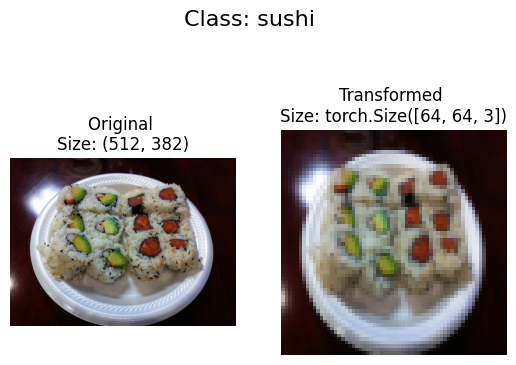

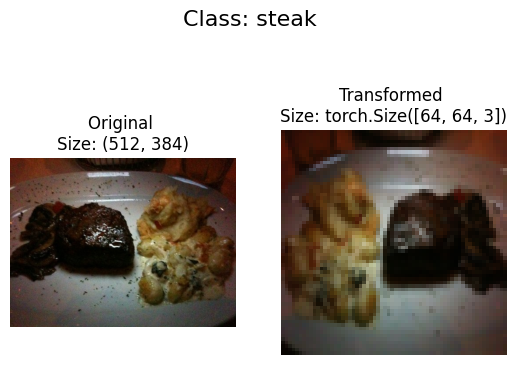

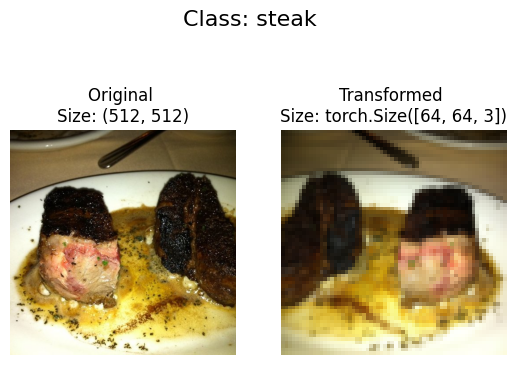

In [14]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3,seed=42):
  """
  Selects random images from a path then loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot image
      transformed_image = transform(f).permute(1,2,0) # we do this to bring the color channels to the last position : (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # transform for the data
                                  target_transform = None) # transform for the label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as a list
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)


(225, 75)

### 4.1 Turn loaded images into `Dataloaders`

A data loader is going to help us turn datasets into iterables and

In [22]:
# Turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= BATCH_SIZE,
                              num_workers = 1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size= BATCH_SIZE,
                              num_workers = 1,
                              shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c47710c1f90>,
 <torch.utils.data.dataloader.DataLoader at 0x7c47710c3700>)

In [23]:
len(train_dataloader)

225

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1
print(f"Image shape: {img.shape} -> [batch_size,color_channels,height, width]")
print(f"Image shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size,color_channels,height, width]
Image shape: torch.Size([1])
